In [42]:
DATA_FILE ='../data-cleaned/crosswalk_2014_15.csv'

In [43]:
####################################################
# Boilerplate import/setup code for general analysis
####################################################

import datetime as dt
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

####################################################
# everett@bayesimpact.org
####################################################

In [52]:
# Helpers (currently cut and paste around different notebooks... oops)

def percentify_axis(ax, which):
    which = which.lower()
    if which in ('x', 'both'):
        ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])
    if which in ('y', 'both'):
        ax.set_yticklabels(['%.0f%%' % (t*100) for t in ax.get_yticks()])

color_idx = 0
CYCLE_COLORS = sns.color_palette()
def next_color():
    global color_idx
    c = CYCLE_COLORS[color_idx] 
    color_idx = (color_idx + 1) % len(CYCLE_COLORS)
    return c

def count_unique(s):
    values = s.unique()
    return sum(1 for v in values if pd.notnull(v))

def missing_pct(s):
    missing = N - s.count()
    return missing * 100.0 / N

def complete_pct(s):
    return 100 - missing_pct(s)

def summarize_completeness_uniqueness(df):
    print '*** How complete is each feature? How many different values does it have? ***'
    rows = []
    for col in df.columns:
        rows.append([col, '%.0f%%' % complete_pct(df[col]), count_unique(df[col])])
    return pd.DataFrame(rows, columns=['Column Name', 'Complete (%)','Unique Values'])

def summarize_completeness_over_time(df, time_col, transpose=True):
    print '*** Data completeness over time per column ***'
    x = df.groupby(time_col).count()
    x = x.div(df.groupby(time_col).size(), axis=0)
    for col in x.columns:
        x[col] = x[col].apply(lambda value: '%.0f%%' % (value * 100))
    if transpose:
        return x.T
    return x

def plot_top_hist(df, col, top_n=10, skip_below=.01):
    '''Plot a histogram of a categorical dataframe column, limiting to the most popular.'''
    if df[col].isnull().all():
        return
    counts = df[col].value_counts(True, ascending=True)
    if counts.max() < skip_below:
        print 'Skipping "%s" histogram -- most common value is < %.0f%% of all cases' % (col, skip_below*100)
        return
    fig, ax = plt.subplots(1)
    explanation = ''
    if len(counts) > top_n:
        explanation = ' (top %d of %d)' % (top_n, len(counts))
        counts = counts.iloc[-top_n:]
    explanation += ' -- %.0f%% missing' % (missing_pct(df[col]))
    counts.plot(kind='barh', ax=ax, color=next_color())
    ax.set_title('Rows by "%s"%s' % (col, explanation))
    ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])


In [53]:
df = pd.read_csv(DATA_FILE, header=0)
print '%d rows %d columns' % df.shape
N = len(df)
df.head()

132505 rows 21 columns


,State,DentalPlan,PlanID_2014,IssuerID_2014,MultistatePlan_2014,MetalLevel_2014,ChildAdultOnly_2014,FIPSCode,ZipCode,CrosswalkLevel,ReasonForCrosswalk,PlanID_2015,IssuerID_2015,MultistatePlan_2015,MetalLevel_2015,ChildAdultOnly_2015,AgeOffPlanID_2015,IssuerID_AgeOff2015,MultistatePlan_AgeOff2015,MetalLevel_AgeOff2015,ChildAdultOnly_AgeOff2015
0,AK,Y,21989AK0010001,21989,N,Low,0,2013,0,1,6,21989AK0030001,21989,N,High,0,00000XX0000000,0,NaN,NaN,NaN
1,AK,Y,21989AK0010001,21989,N,Low,0,2016,0,1,6,21989AK0030001,21989,N,High,0,00000XX0000000,0,NaN,NaN,NaN
2,AK,Y,21989AK0010001,21989,N,Low,0,2020,0,1,6,21989AK0030001,21989,N,High,0,00000XX0000000,0,NaN,NaN,NaN
3,AK,Y,21989AK0010001,21989,N,Low,0,2050,0,1,6,21989AK0030001,21989,N,High,0,00000XX0000000,0,NaN,NaN,NaN
4,AK,Y,21989AK0010001,21989,N,Low,0,2060,0,1,6,21989AK0030001,21989,N,High,0,00000XX0000000,0,NaN,NaN,NaN


In [54]:
summarize_completeness_uniqueness(df)

*** How complete is each feature? How many different values does it have? ***


,Column Name,Complete (%),Unique Values
0,State,100%,35
1,DentalPlan,100%,2
2,PlanID_2014,100%,3514
3,IssuerID_2014,100%,300
4,MultistatePlan_2014,100%,2
5,MetalLevel_2014,100%,7
6,ChildAdultOnly_2014,100%,3
7,FIPSCode,100%,2545
8,ZipCode,100%,449
9,CrosswalkLevel,100%,5


Skipping "PlanID_2014" histogram -- most common value is < 1% of all cases
Skipping "FIPSCode" histogram -- most common value is < 1% of all cases


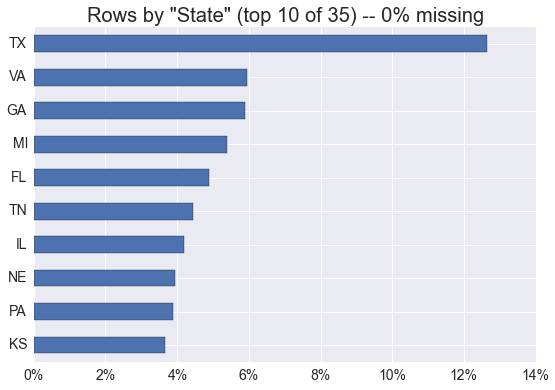

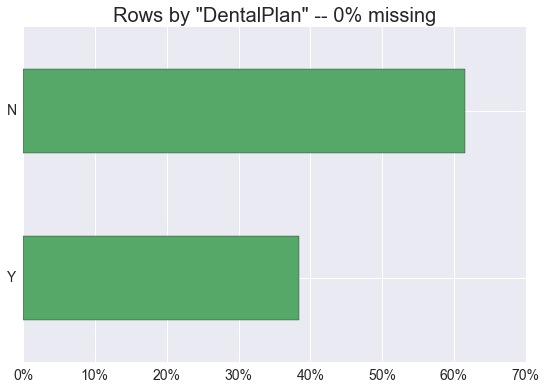

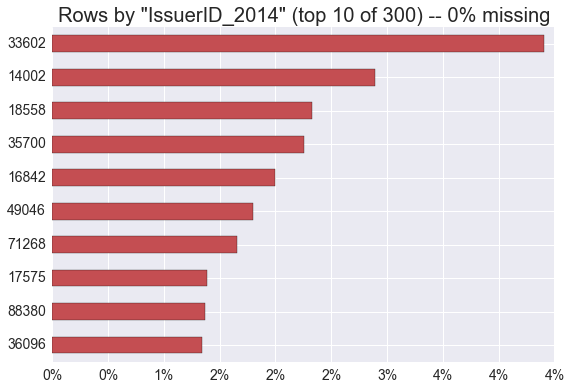

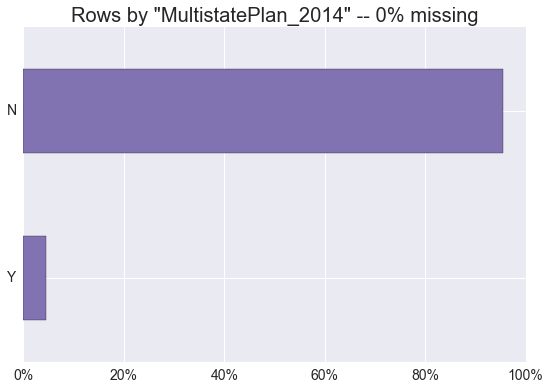

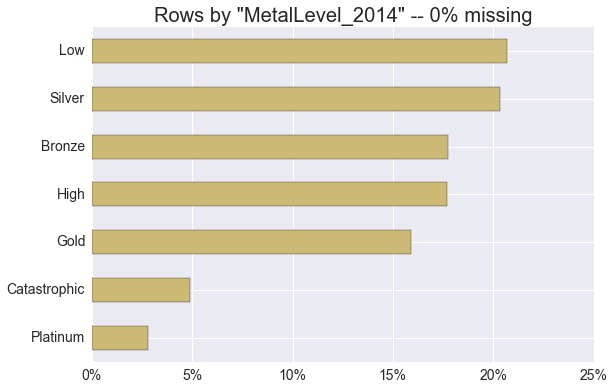

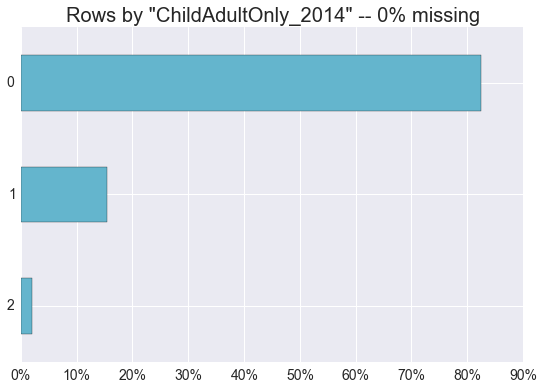

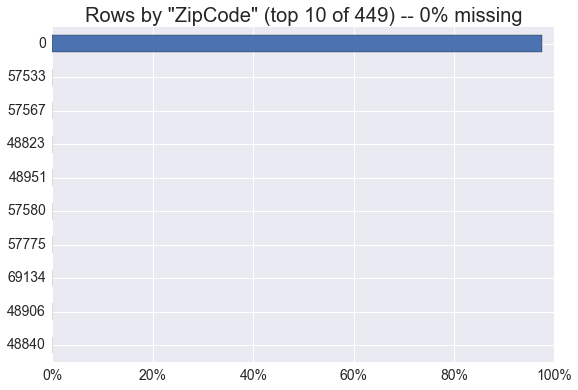

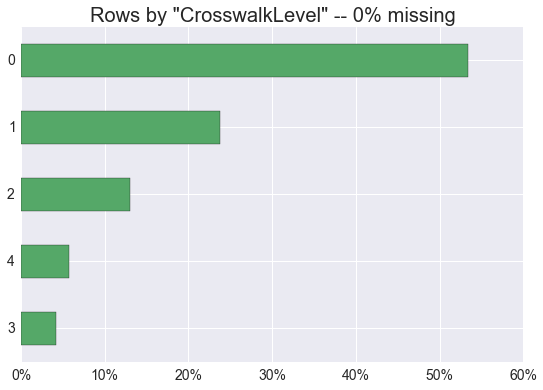

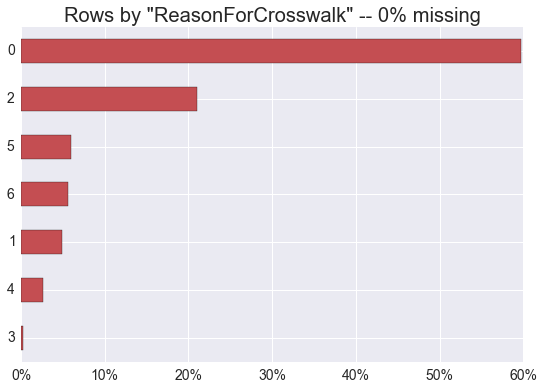

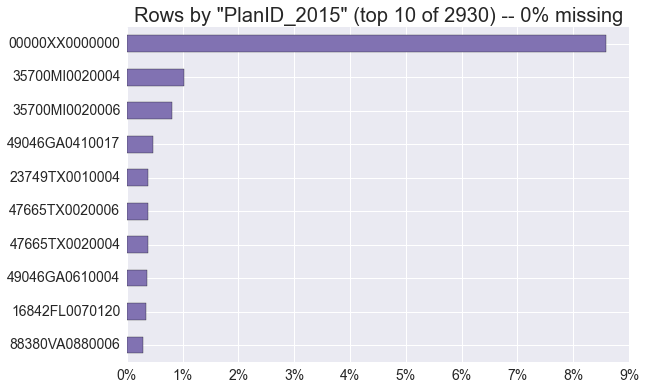

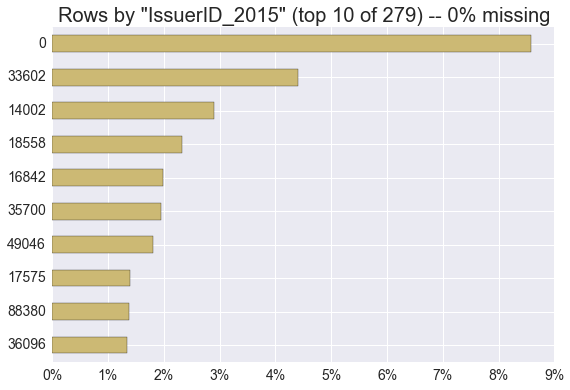

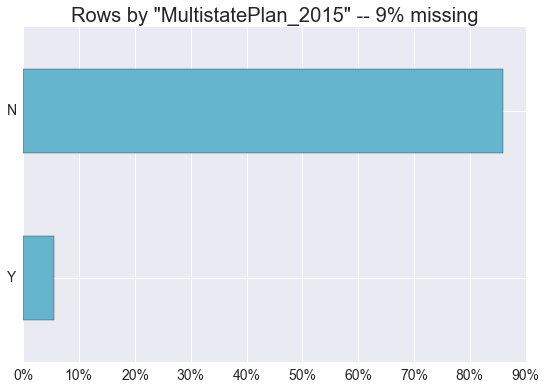

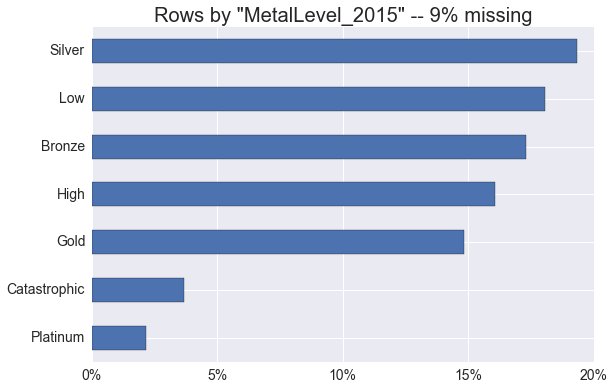

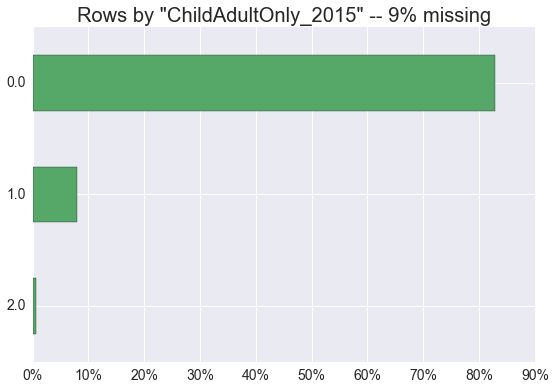

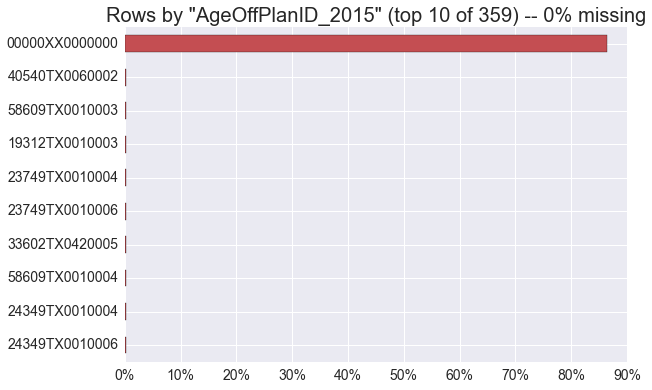

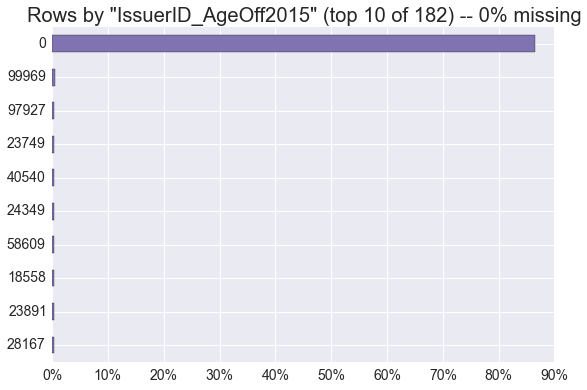

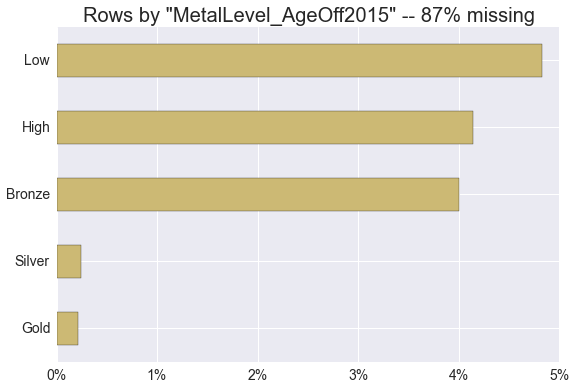

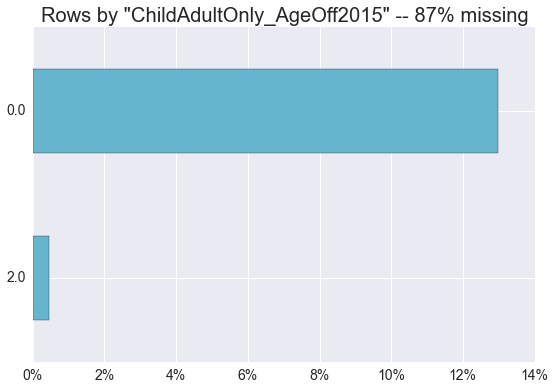

In [55]:
for col in df.columns:
    counts = df[col].value_counts(True, ascending=True)
    if counts.max() == None:
        continue
    else: plot_top_hist(df, col)